In [1]:
from tools import vis, util

import json, imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data
Data is a long format table with participant, activity type, segment, and observation

In [2]:
with open('./processed/sports.json') as fp:
    obj = json.load(fp)
    df = pd.DataFrame(**obj['X'])
    
df.head()

,participant,activity,segment,T_zacc
0,p4,stairs ascending,s06,0.94689
1,p4,stairs ascending,s06,1.18060
2,p4,stairs ascending,s06,1.10330
3,p4,stairs ascending,s06,1.17890
4,p4,stairs ascending,s06,1.43580


# Process the data
Groups by participant, activigy, segment, and processes into periodograms. Columns are the frequency.

In [3]:
from scipy.signal import welch

def welch_features(*args, **kwargs):
    return pd.Series(*welch(*args, **kwargs)[::-1])
    
cols = ['participant', 'activity', 'segment']

X_traj = df.set_index(cols).sort_index()

X = df.groupby(cols)\
    .T_zacc.apply(welch_features)\
    .unstack()


X.head()

/Users/aren438/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  .format(nperseg, input_length))


0.000       0.008       0.016       0.024  \
participant activity   segment                                                  
p1          basketball s01       0.048445   51.715034  118.357602  156.080438   
                       s02       5.832479   15.078752   16.050456   19.498312   
                       s03       1.079669   21.829120  213.414128  196.368255   
                       s04      99.374908  148.589707    7.187109    8.918887   
                       s05      12.845065   97.025129  144.993756   38.512705   

                                     0.032      0.040      0.048      0.056  \
participant activity   segment                                                
p1          basketball s01      112.995539  63.899809  55.876915  32.400204   
                       s02       23.654993  19.342244  10.854543   1.539342   
                       s03       33.053417   7.874206  30.114334   5.715232   
                       s04        0.314542  32.853834  49.979444  54.764303   
                       s05        5.243358  16.820135  25.955165  25.585855   

                                    0.064      0.072    ...          0.424  \
participant activity   segment                          ...                  
p1          basketball s01      13.671306   1.915874    ...       0.627497   
                       s02       2.612106   1.936942    ...       1.191912   
                       s03       9.588398  19.270858    ...      13.053484   
                       s04      64.754244  86.943379    ...       5.685127   
                       s05      48.593071  73.212089    ...       6.490054   

                                   0.432     0.440      0.448     0.456  \
participant activity   segment                                            
p1          basketball s01      0.095777  0.137410   0.490178  0.365741   
                       s02      3.552851  5.398154   6.853547  1.031370   
                       s03      7.768878  4.936896  10.938111  1.901131   
                       s04      3.287065  5.161002   2.167696  0.969108   
                       s05      4.909137  3.972352   5.654787  5.657129   

                                   0.464      0.472      0.480      0.488  \
participant activity   segment                                              
p1          basketball s01      0.657773   0.948325   1.520552   0.565132   
                       s02      1.586954   7.912616   8.203614   5.063464   
                       s03      1.757613   0.189021   2.277847   1.554289   
                       s04      2.667449   3.762034   5.960384   2.240860   
                       s05      6.406140  10.633551  18.480746  23.159890   

                                    0.496  
participant activity   segment             
p1          basketball s01       0.110026  
                       s02       1.220632  
                       s03       0.061559  
                       s04       2.049929  
                       s05      25.586604  

[5 rows x 63 columns]

# Apply the pipeline

In [4]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

pos = pd.DataFrame(Pipeline([
    ('norm', Normalizer(norm='l1')),
    ('rot', PCA()),
    ('proj', Isomap())
]).fit_transform(X), index=X.index)

# Visualize
Draw a simple timeseries for each example. Color is the broad activity type.

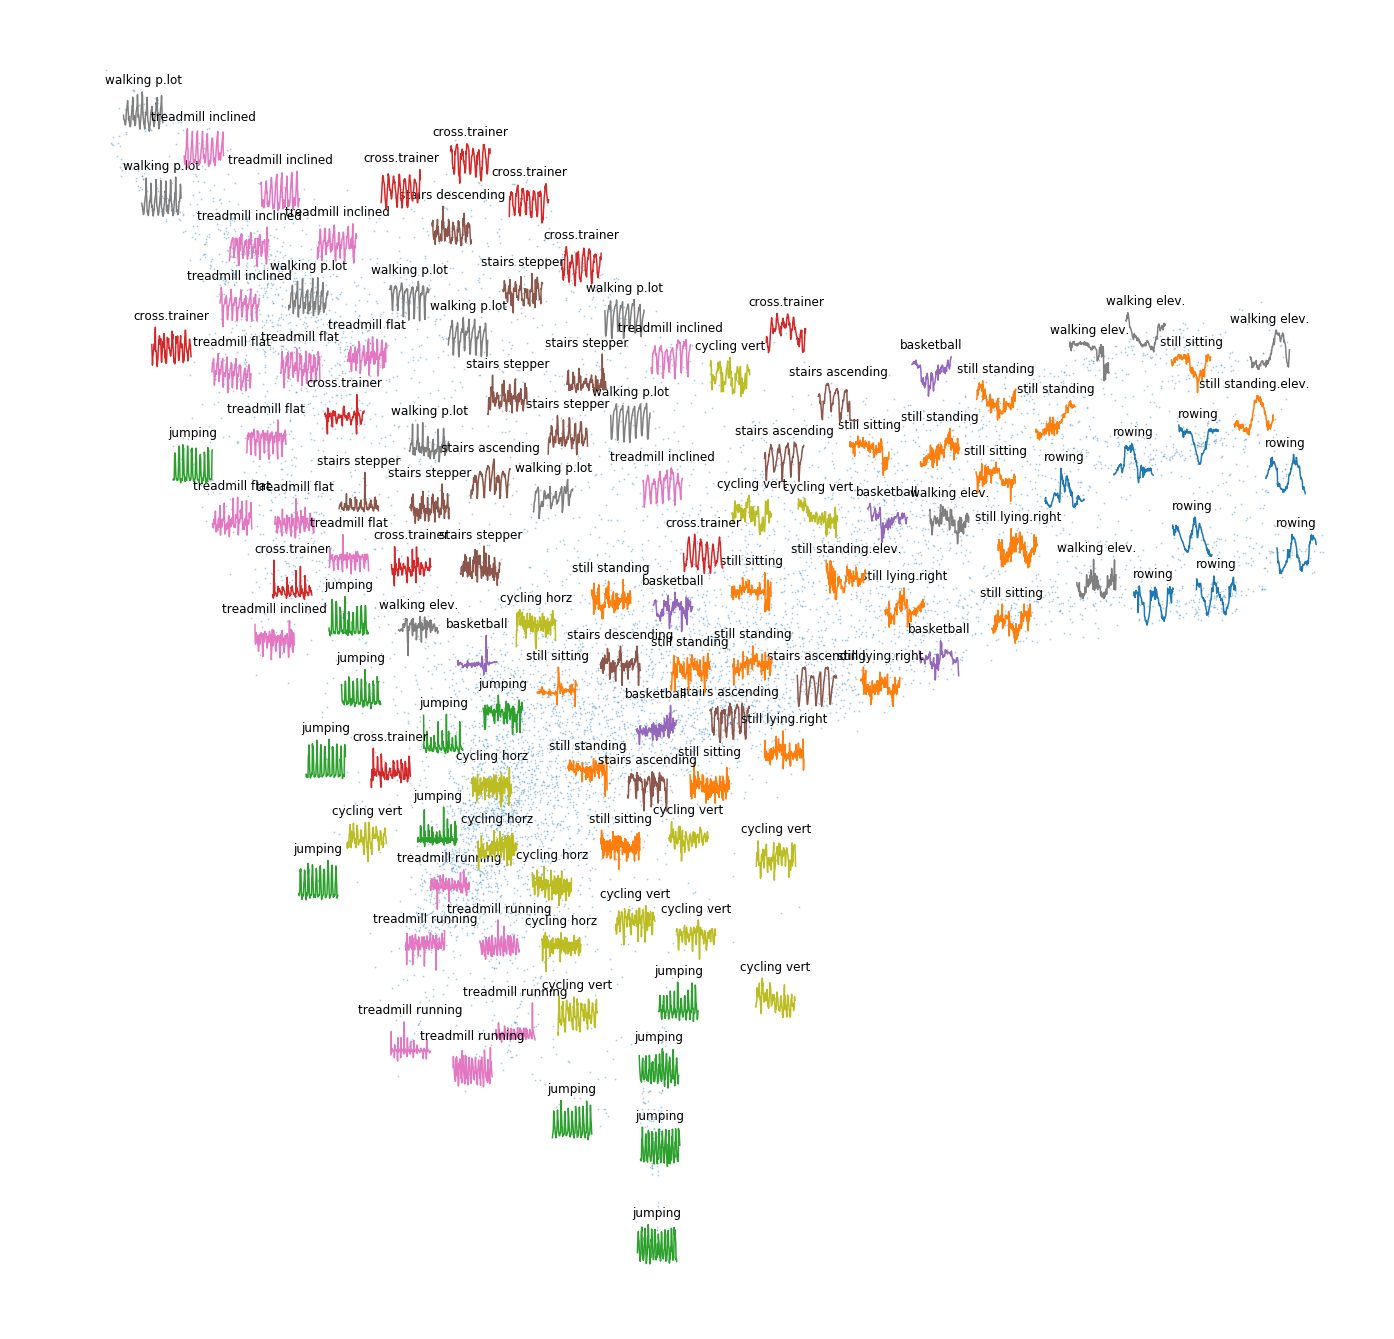

In [5]:
def activity_type(a):
    return a.split(' ')[0]

colors = {v: plt.cm.tab10(i) for i, v in enumerate(set(map(activity_type, df.activity.unique())))}

plt.figure(figsize=(24, 24))
plt.axis('off')

for x, ax in vis.subplots_scatter(pos, s=.025, scatter_args=dict(s=1, alpha=.25)):
    xi = x[0]
    
    plt.plot(*X_traj.loc[xi].values.T, color=colors[activity_type(xi[1])])
    plt.axis('off')
    plt.title(xi[1])